In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
#!nvidia-smi

In [42]:
import os
import glob
import random
import matplotlib.pyplot as plt

# Increase plot size for better visibility
plt.rcParams['figure.figsize'] = (10, 6)

# Path to the extracted dataset directory:
DATASET_PATH = "/kaggle/input/fruit-and-vegetable-image-recognition/train"
# For example: DATASET_PATH = "/kaggle/input/fruit-and-vegetable-image-recognition/train"


In [43]:
# Search for all image files in the directory
image_paths = glob.glob(os.path.join(DATASET_PATH, "*", "*.*"))

total_images = len(image_paths)
print(f"Total number of images in the dataset: {total_images}")


Total number of images in the dataset: 3115


Number of classes: 36
Class 'apple': 68 images
Class 'banana': 75 images
Class 'beetroot': 88 images
Class 'bell pepper': 90 images
Class 'cabbage': 92 images
Class 'capsicum': 89 images
Class 'carrot': 82 images
Class 'cauliflower': 79 images
Class 'chilli pepper': 87 images
Class 'corn': 87 images
Class 'cucumber': 94 images
Class 'eggplant': 84 images
Class 'garlic': 92 images
Class 'ginger': 68 images
Class 'grapes': 100 images
Class 'jalepeno': 88 images
Class 'kiwi': 88 images
Class 'lemon': 82 images
Class 'lettuce': 97 images
Class 'mango': 86 images
Class 'onion': 94 images
Class 'orange': 69 images
Class 'paprika': 83 images
Class 'pear': 89 images
Class 'peas': 100 images
Class 'pineapple': 99 images
Class 'pomegranate': 79 images
Class 'potato': 77 images
Class 'raddish': 81 images
Class 'soy beans': 97 images
Class 'spinach': 97 images
Class 'sweetcorn': 91 images
Class 'sweetpotato': 69 images
Class 'tomato': 92 images
Class 'turnip': 98 images
Class 'watermelon': 84 imag

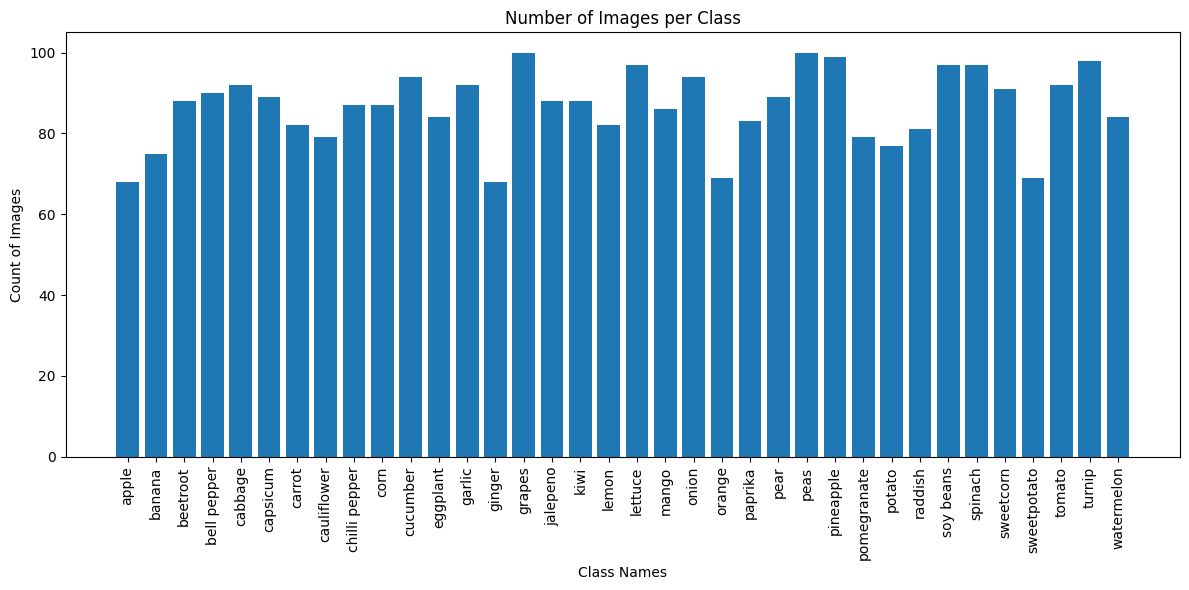

In [44]:
# List all subdirectories (each subdirectory = one class)
class_names = sorted([
    d for d in os.listdir(DATASET_PATH) 
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Dictionary for storing counts per class
class_counts = {}

for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    # Count number of images in each class folder
    class_counts[class_name] = len(os.listdir(class_dir))

# Print class names and counts
for cls, cnt in class_counts.items():
    print(f"Class '{cls}': {cnt} images")

# Plot histogram of the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.xlabel("Class Names")
plt.ylabel("Count of Images")
plt.tight_layout()
plt.show()


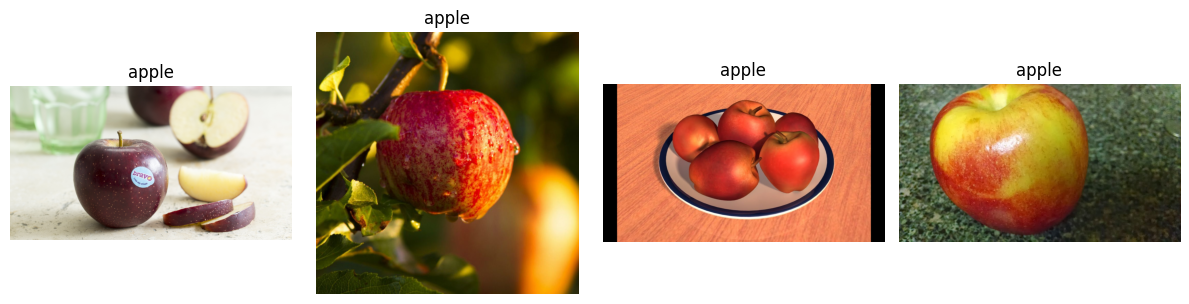

In [45]:
for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    all_images = os.listdir(class_dir)
    
    # If there are fewer than 4 images, just sample all
    n_to_show = min(4, len(all_images))
    sample_images = random.sample(all_images, n_to_show)
    
    # Create a figure per class
    plt.figure(figsize=(12, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_dir, img_name)
        image = plt.imread(img_path)
        
        plt.subplot(1, n_to_show, i+1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Remove the break below if you want to see images for ALL classes.
    # Otherwise, this break will just show the first few classes for brevity.
    break


In [46]:
# PyTorch
import torch
print("GPU is available:", torch.cuda.is_available())

# TensorFlow
import tensorflow as tf
print("Available physical devices:", tf.config.list_physical_devices('GPU'))

GPU is available: True
Available physical devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [47]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms, models
from torchmetrics import Accuracy
from PIL import Image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from argparse import Namespace

# Example directory structure
TRAIN_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/train"
VALID_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/validation"  # or test
TEST_DIR = "/kaggle/input/fruit-and-vegetable-image-recognition/test"

IMG_SIZE = (150, 150)  # We'll resize images to 150x150
BATCH_SIZE = 32

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    print("using {}".format(torch.cuda.get_device_name(0)))
else:
    print("using CPU")

print(torch.__version__)  # Should be >= 2.0
print(pl.__version__)

using Tesla P100-PCIE-16GB
2.5.1+cu121
2.5.0.post0


In [48]:
# Hyperparameters
hparams = Namespace(
    # Data
    entity="25DLAAU",
    exp_name='mp_age_classifier',  # Unique name for model and logs
    image_size=150,  # Images size for input to model
    image_channels=3,  # 3 for RGB, 1 for grayscale images
    # Model
    num_conv_blocks=2,  # Number of Conv->Pool blocks
    filters=32,  # Number of filters in the first block
    kernel_size=3,  # Kernel size for convolutional layers
    dropout_rate=0.0,  # Dropout rate
    num_classes=36,  # Number of output classes
    # Training
    wandb_project='Miniproject',
    group="learning_rate_experiment",
    accelerator='gpu',  # Use 'gpu' for GPU training, 'cpu' for CPU
    devices=1,  # Number of GPUs or CPUs
    max_epochs=10,  # Number of epochs
    learning_rate=1e-3,  # Learning rate (default, will be overridden)
    batch_size=8,  # Batch size
    n_workers=4  # Number of data loader workers
)

In [49]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_conv_blocks=2, filters=32, kernel_size=3, dropout_rate=0.0, num_classes=10):
        super(CNNModel, self).__init__()
        self.layers = nn.ModuleList()
        in_channels = 3
        
        for i in range(num_conv_blocks):
            out_channels = filters * (2 ** i)
            self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding='same'))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.MaxPool2d(2))
            self.layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(out_channels * (IMG_SIZE[0] // (2 ** num_conv_blocks)) * (IMG_SIZE[1] // (2 ** num_conv_blocks)), 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Wrap the CNNModel in a PyTorch Lightning Module
class LitModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        
        # Initialize the CNNModel
        self.model = CNNModel(
            num_conv_blocks=hparams.num_conv_blocks,
            filters=hparams.filters,
            kernel_size=hparams.kernel_size,
            dropout_rate=hparams.dropout_rate,
            num_classes=hparams.num_classes
        ).to(device)
        
        # Loss function
        self.criterion = nn.CrossEntropyLoss()
        
        # Metrics
        self.train_accuracy = Accuracy(task='multiclass', num_classes=hparams.num_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=hparams.num_classes)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=hparams.num_classes)
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_accuracy, on_step=True, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)
        
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', self.test_accuracy, on_step=True, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


In [50]:
from torchvision.datasets import ImageFolder
from PIL import Image
import os

# Custom loader to handle transparency
def load_rgb_image(path):
    img = Image.open(path)
    
    # Convert Palette images to RGBA first, then to RGB
    if img.mode == 'P':
        img = img.convert("RGBA").convert("RGB")
    elif img.mode == 'RGBA':
        img = img.convert("RGB")
        #print(f"After conversion: {path}, Mode: {img.mode}")  # Debug print
    
    return img

# Define transformations
transform = transforms.Compose([
        transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load datasets (equivalent to image_dataset_from_directory)
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=transform, loader=load_rgb_image)
val_ds = datasets.ImageFolder(VALID_DIR, transform=transform,loader=load_rgb_image)
test_ds = datasets.ImageFolder(TEST_DIR, transform=transform,loader=load_rgb_image)


#train_ds = CustomImageFolder(TRAIN_DIR, transform=transform)
#val_ds = CustomImageFolder(VALID_DIR, transform=transform)
#test_ds = CustomImageFolder(TEST_DIR, transform=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=hparams.n_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,num_workers=hparams.n_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,num_workers=hparams.n_workers, pin_memory=True)


In [51]:

os.environ["WANDB_API_KEY"] = "a4103e1c89f2827bf9c5f11c461ad016034e35a2"

import wandb
wandb.login()


from pytorch_lightning.loggers import WandbLogger


In [52]:
wandb.finish()

# Train with different learning rates
learning_rates = [1e-3]
results_lr = {}

for lr in learning_rates:

    # Update learning rate in hparams
    hparams.learning_rate = lr

    run_name = f"lr_{lr}"

    wandb.init(entity=hparams.entity, project=hparams.wandb_project,config=vars(hparams), settings=wandb.Settings(init_timeout=300),name=run_name)

    print(f"Run name: {wandb.run.name}")
    logger = WandbLogger(
        save_dir='wandb_logs/',
        offline=False,
        project=hparams.wandb_project,
        log_model=False,
        name=run_name  # Set the same name here
    )
    
    # Initialize the model
    model = LitModel(hparams).to(device)
    
    # Initialize the Trainer
    trainer = pl.Trainer(accelerator='gpu', 
                     max_epochs=hparams.max_epochs,
                     devices=1, 
                     logger=logger,
                    log_every_n_steps = 100
                     )
    
    # Train the model
    trainer.fit(model, train_loader, val_loader)
    
    # Test the model
    test_results = trainer.test(model, test_loader)
    test_acc = test_results[0]['test_acc_epoch']
    
    # Store results
    results_lr[lr] = test_acc
    print(f"Learning Rate={lr}, Test Accuracy={test_acc:.4f}")

    # Finish WandB run
    wandb.finish()
    print("next one")


Run name: lr_0.001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9637883305549622     │
│      test_loss_epoch      │    0.24993932247161865    │
└───────────────────────────┴───────────────────────────┘

Learning Rate=0.001, Test Accuracy=0.9638


epoch,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
test_acc_epoch,▁
test_loss_epoch,▁
test_loss_step,█▄▄▁▁▁▁▁▇▂▄▁
train_acc_epoch,▁▂▄▆▇█████
train_loss_epoch,█▆▅▃▂▁▁▁▁▁
train_loss_step,█▆▄▂▁▁▂▁▁
trainer/global_step,▁▁▁▂▂▁▁▁▄▄▁▁▁▁▁▅▅▅▁▁▂▂▂▂▆▂▂▂█▂▂▂▂▂▂▁▁▁▁▁
val_acc_epoch,▁▃▆███████
val_loss_epoch,█▆▃▁▁▁▁▁▁▁
val_loss_step,▇█▆█▇▅▇▄▆▇▆▂▃▃▂▃▂▂▂▂▂▂▁▂▁▂▁▃▁▁▂▁▁▃▂▃▁▃▂▁


next one
